<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/BareBonesAnalysis/Step2.1_2assets_no_timedimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import numpy.matlib
from scipy.stats import norm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import seaborn as sns

In [3]:
# # %%
# params ={ "mu": 0.1,
#          "sigma": 0.2,
#          "T" : 1}

#%% ANN
class MyNet(nn.Module):
    
    def __init__(self, n ):
        super(MyNet, self).__init__()
        
        # 1 input layer (X_T^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, 2)
        #self.f_h2_to_out = nn.LogSoftmax(n, 3)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        
        return y
    

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
print(device)    

cuda


In [5]:
# params = {
#     "S0" : np.array([1]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([.2]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.00,
#     "delta" : np.array([0.7]),
#     "T" : 5
#     }

params = {
    "S0" : np.array([1, 2]),
    "mu" : np.array([0.05, 0.06]),
    "sigma" : np.array([0.1, 0.12]),
    "rho" : np.array([[1, .25],[.25,1]]),
    "rf" : 0.00,
    "delta" : np.array([0.25, 0.75])
    }

def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= params["mu"].shape[0]
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S

In [6]:
#%% Compute RM from samples
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1        
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* alpha* torch.mean(X[X<=LQtl]) \
                        + (1-p) *(1-beta) * torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [7]:
Ndt=500
T =5
X0=1
num_asset = 2
Nsims=5000
t, S = SimPath(Ndt, params, T=T, Nsims=Nsims) 

In [8]:
S.shape

(501, 5000, 2)

In [9]:
# %% compute Wasserstein distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 

# %% simulate and compute RM


def SimRM(net, params, Nsims, type="alpha-beta", device=device ):
    
    # a sample sim
#     X = np.exp((params["mu"]-0.5*params["sigma"]**2)*params["T"]\
#                +params["sigma"]*np.sqrt(params["T"])*np.random.randn(Nsims,1))
    
#     X_t = torch.tensor(X, dtype=torch.float, requires_grad=False)
    
#     Y_t = net(X_t)

    Ndt=500
    T =5
    X0=1
    num_asset = 2
    t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
  
    wt = net(S_t) 

    # Y_t = w_t[-1,:].reshape(-1,1)
    # X_t = S_t[-1,:].reshape(-1,1)
    dt = t[1]-t[0]
    S_Ret = (S_t[1:,:,:]-S_t[:-1,:,:])/S_t[:-1,:,:]
    
    #Benchmark Delta and return
    Delta_t = torch.zeros((Ndt, Nsims, num_asset), \
                                 dtype=torch.float, requires_grad=False, device=device)
    # note only 90% invested in risky assets here... 10% in risk-free
    delta = torch.tensor(params["delta"],requires_grad=False, device=device)
    delta_r = 1 - torch.sum(delta)
    Delta_t += delta 

    # accumulate returns as we go along
    Benchmark_Ret = delta_r * params["rf"] * dt+ torch.sum(Delta_t * S_Ret , axis=2)
    
    BenchmarkVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)
    BenchmarkVal_path[0,:]  = X0
    BenchmarkVal_path[1:,:] = X0*torch.cumprod( (1.0+Benchmark_Ret), axis=0)
    BenchmarkVal_T = BenchmarkVal_path[-1,:].reshape(-1,1)

     # the candidate portolio
    Portfolio_Ret = (1-torch.sum(wt[:-1,:,:], axis=2)) * params["rf"] * dt+ torch.sum(wt[:-1,:,:] * S_Ret , axis=2)
    
    PortfolioVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)    
    PortfolioVal_path[0,:] = X0
    PortfolioVal_path[1:,:] = X0*torch.cumprod( (1.0+Portfolio_Ret), axis=0)
    PortfolioVal_T = PortfolioVal_path[-1,:].reshape(-1,1)

    Y_t = PortfolioVal_T
    X_t = BenchmarkVal_T    
    
    wass_dist = getWassDistance(X_t, Y_t)
    
    RiskMeasure = GetRiskMeasure(Y_t, "alpha-beta") 
    
    return RiskMeasure, wass_dist, X_t, Y_t

In [10]:
# t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
# S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
# Return = S_t[:,1:] - S_t[:,:-1]    
# Return.shape


In [11]:
# S_t.shape

In [12]:
# w_t = net(S_t) 

# #S and w at maturity as the sum of all the returns 

# Y_t = w_t[-1,:].reshape(-1,1)
# X_t = S_t[-1,:].reshape(-1,1)

# wass_dist = getWassDistance(X_t, Y_t)

# RiskMeasure = GetRiskMeasure(Y_t, "alpha-beta") 
    

In [13]:
# %%
def PlotHists(X, Y):
    
    bins = np.linspace(0,2.5,25)
    
    Xcp = X.clone().cpu().detach().numpy()
    Ycp = Y.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,3,1)
    
    sns.distplot(Xcp, bins = bins, hist=True, kde=True, label='Index')
    sns.distplot(Ycp, bins = bins,  hist=True, kde=True, label='Portfolio')
    plt.legend()    
    
    plt.axvline(np.quantile(Xcp, 0.15),color='k')
    plt.axvline(np.quantile(Ycp, 0.15),color='r')

    plt.xlim(bins[0],bins[-1])
    
    plt.legend()
    
    plt.subplot(1,3,2)
    sns.distplot(Ycp-Xcp, hist=True, kde=True)
    plt.axvline(np.quantile(Ycp-Xcp, 0.05),color='k')

    
    plt.subplot(1,3,3)
    
    plt.plot(np.array([0,bins[-1]]),np.array([0,bins[-1]]))
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    
    plt.ylim(0.9*np.quantile(Xcp,0.01),1.1*np.quantile(Xcp,0.99))
    plt.xlim(0.9*np.quantile(Xcp,0.01),1.1*np.quantile(Xcp,0.99))

    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

In [14]:
    
# #%%
# def PlotStrat(net): 
#     X = np.linspace(0.5,2.2,100).reshape(-1,1)
    
#     # don't think we need sensitivities w.r.t. this as they are fixed per simulation
#     X_t = torch.tensor(X, dtype=torch.float, requires_grad=True)
    
#     Y_t = net(X_t)    
    
#     Y = Y_t.detach().numpy()
    
#     plt.plot(X,Y)
#     plt.plot(X,X,'--k',linewidth=0.5)
    
#     plt.show()
    
# #%%

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

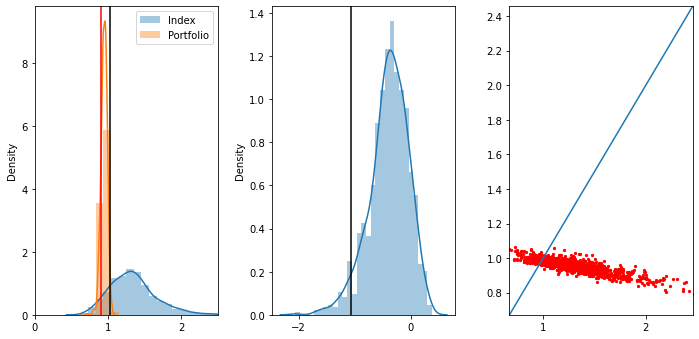

100 Wass Dist: 0.09587688 Risk Measure: -1.2210228 Loss: 9.389488220214844


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

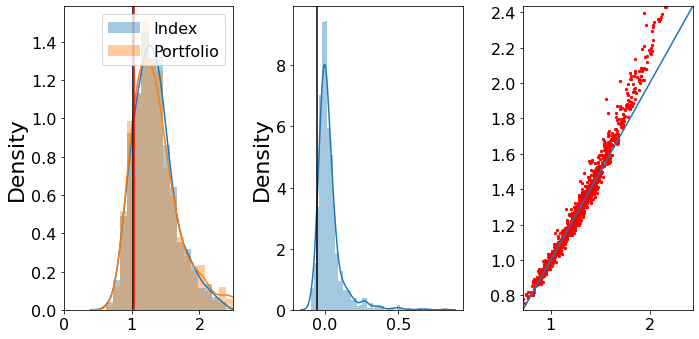

200 Wass Dist: 0.09372707 Risk Measure: -1.1389694 Loss: -0.5694847106933594


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

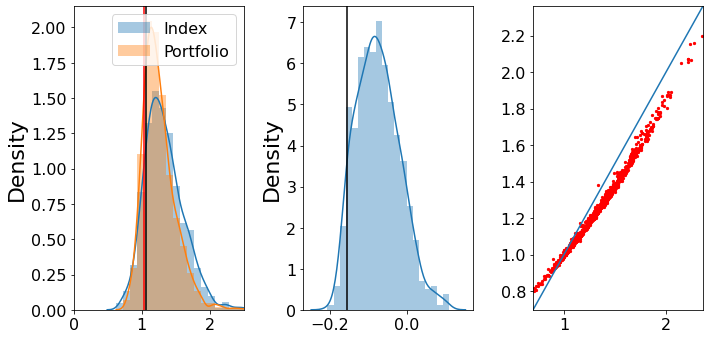

300 Wass Dist: 0.1097 Risk Measure: -1.2153507 Loss: 10.489324569702148


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

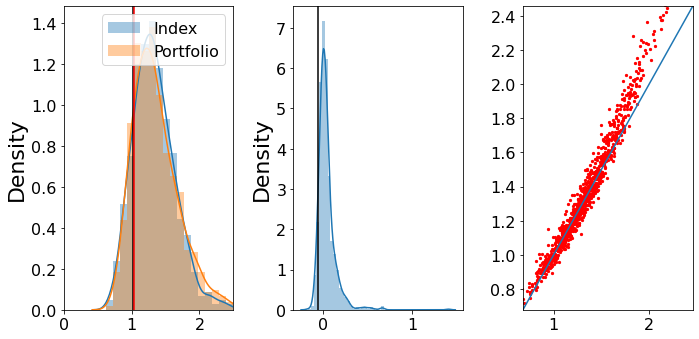

400 Wass Dist: 0.054549392 Risk Measure: -1.1843925 Loss: -0.5921962261199951


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

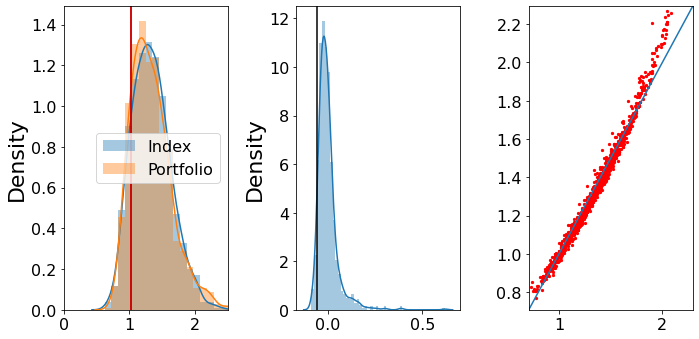

500 Wass Dist: 0.062059425 Risk Measure: -1.2025695 Loss: -0.6012847423553467


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

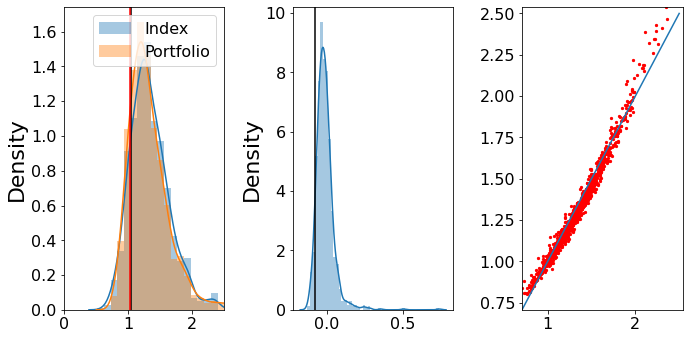

600 Wass Dist: 0.04555597 Risk Measure: -1.188782 Loss: -0.5943909883499146


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

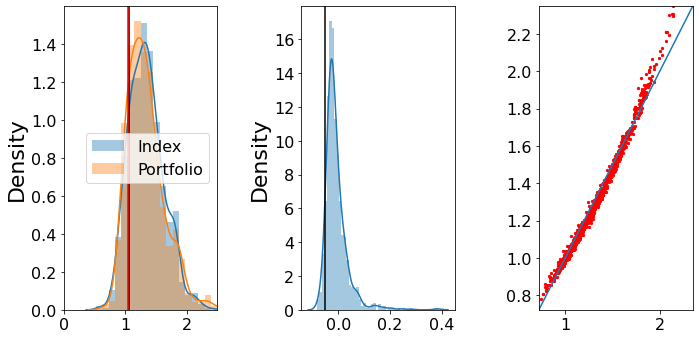

700 Wass Dist: 0.06325342 Risk Measure: -1.1844971 Loss: -0.5922485589981079


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

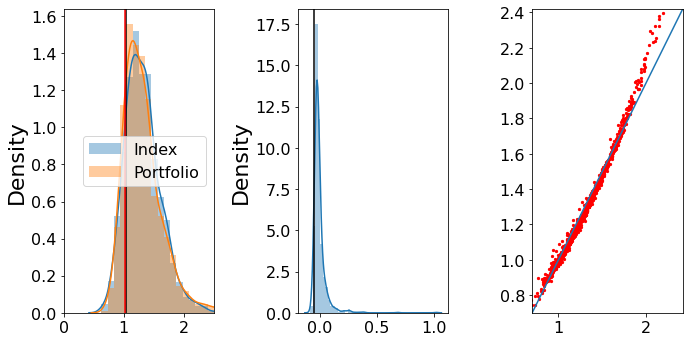

800 Wass Dist: 0.056236286 Risk Measure: -1.2013254 Loss: -0.6006627082824707


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

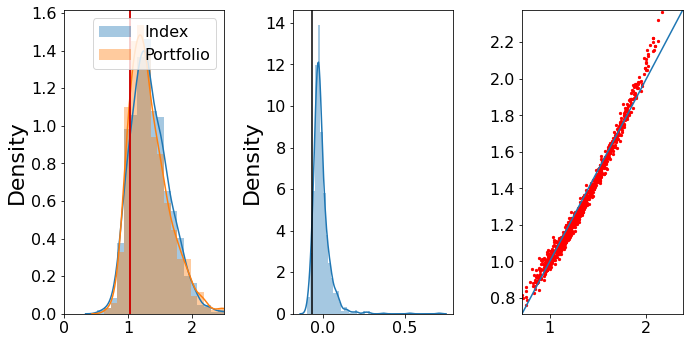

900 Wass Dist: 0.060864836 Risk Measure: -1.1980219 Loss: -0.5990109443664551


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

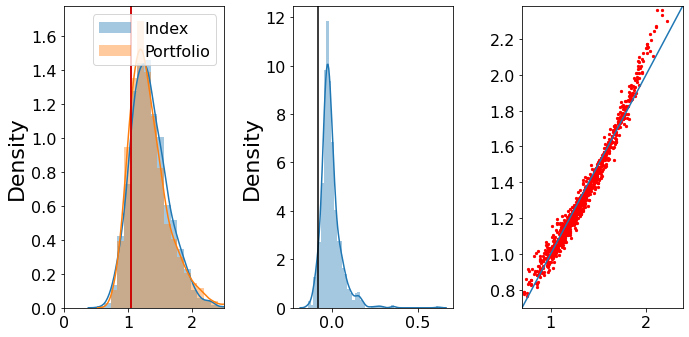

1000 Wass Dist: 0.07239236 Risk Measure: -1.2074513 Loss: 9.39627456665039


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

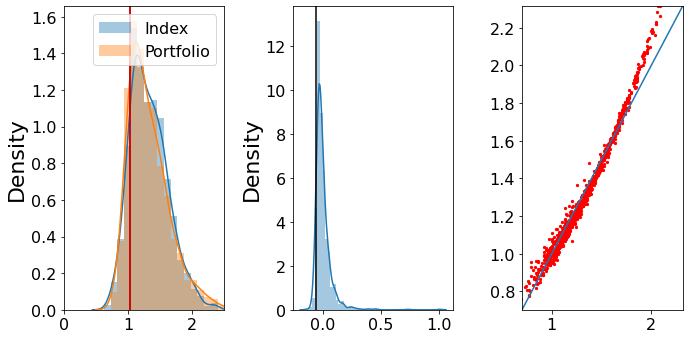

1100 Wass Dist: 0.09128564 Risk Measure: -1.2299004 Loss: 9.385049819946289


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

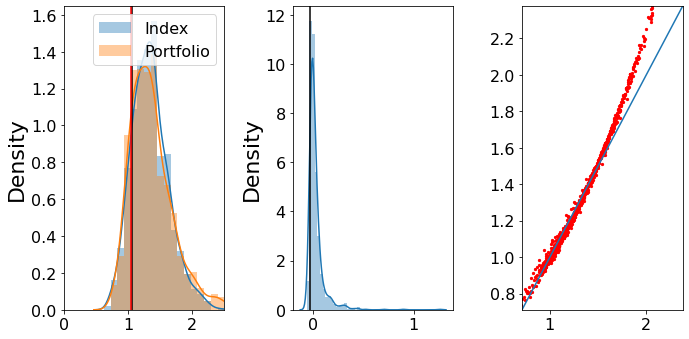

1200 Wass Dist: 0.052151665 Risk Measure: -1.1875592 Loss: -0.5937796235084534


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

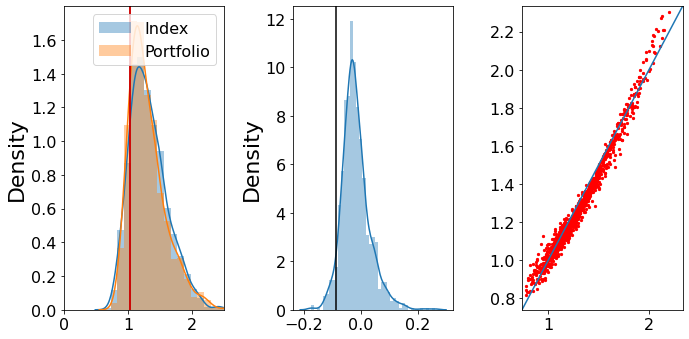

1300 Wass Dist: 0.053266343 Risk Measure: -1.1790171 Loss: -0.5895085334777832


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

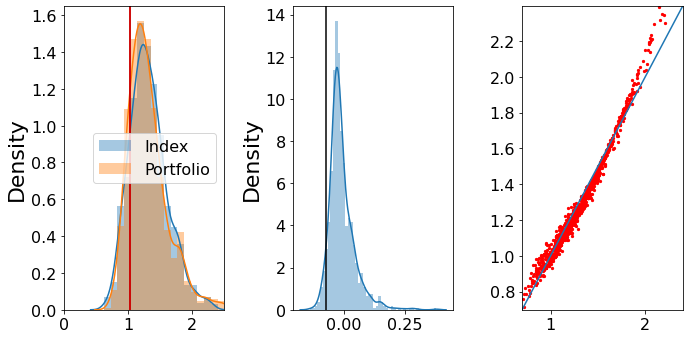

1400 Wass Dist: 0.08189361 Risk Measure: -1.2177266 Loss: 9.39113712310791


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

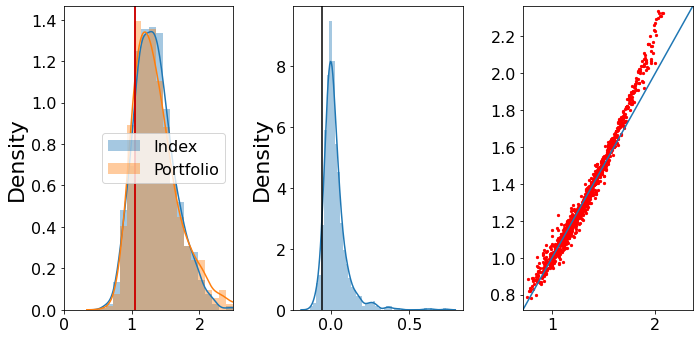

1500 Wass Dist: 0.064855024 Risk Measure: -1.2013875 Loss: -0.6006937623023987


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

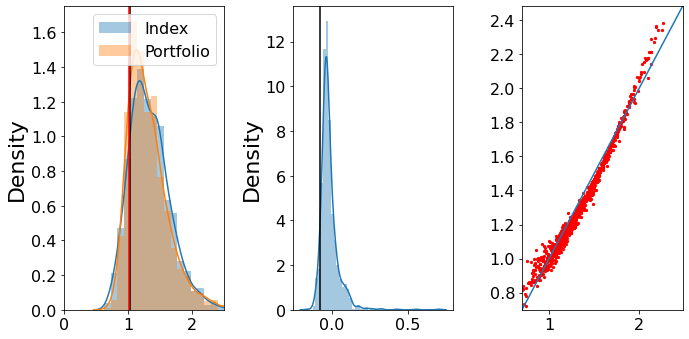

1600 Wass Dist: 0.06456122 Risk Measure: -1.2070476 Loss: 9.396475791931152


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

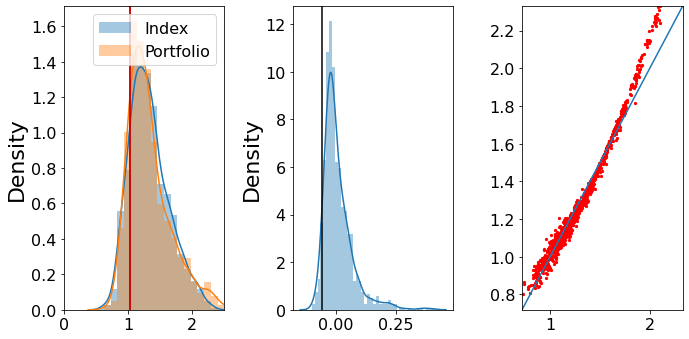

1700 Wass Dist: 0.0600973 Risk Measure: -1.171553 Loss: -0.5857765078544617


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

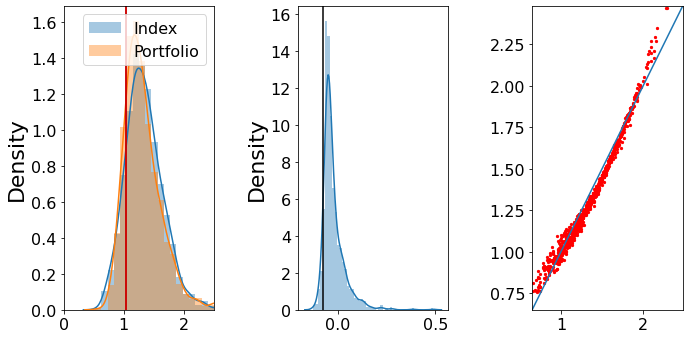

1800 Wass Dist: 0.06833041 Risk Measure: -1.1986388 Loss: -0.5993193984031677


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

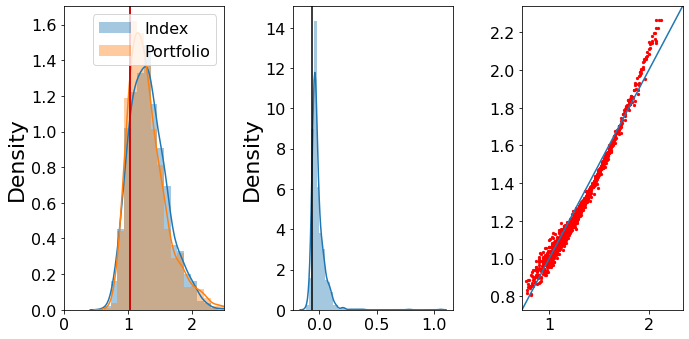

1900 Wass Dist: 0.060785837 Risk Measure: -1.1755862 Loss: -0.5877931118011475


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

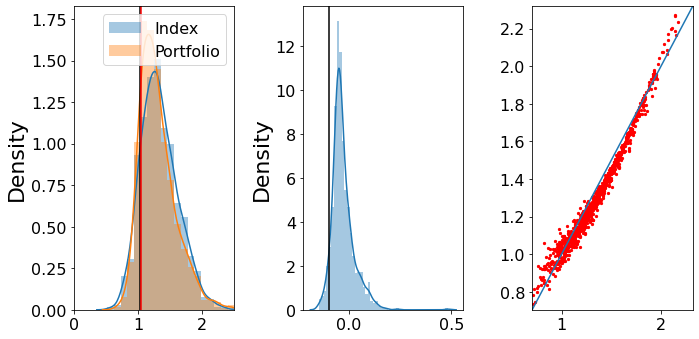

2000 Wass Dist: 0.06015373 Risk Measure: -1.2032464 Loss: -0.6016231775283813


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

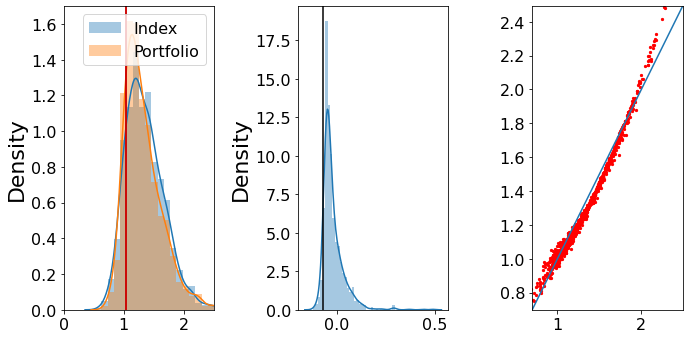

2100 Wass Dist: 0.07396575 Risk Measure: -1.2006543 Loss: 9.399672508239746


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

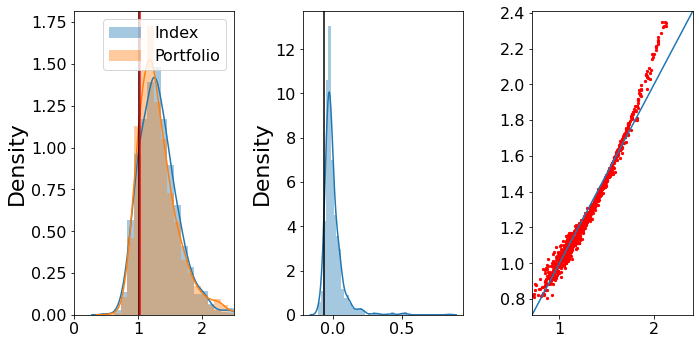

2200 Wass Dist: 0.059197433 Risk Measure: -1.1807659 Loss: -0.5903829336166382


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

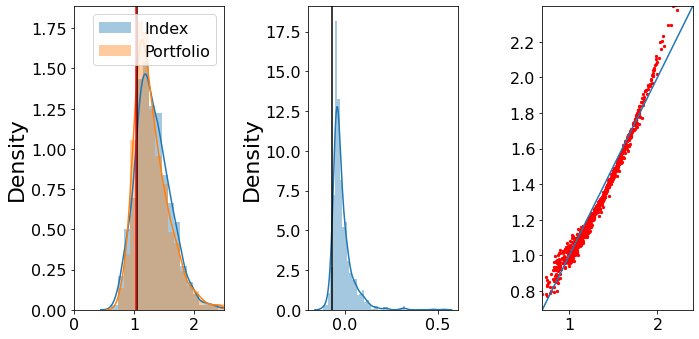

2300 Wass Dist: 0.0825102 Risk Measure: -1.2106943 Loss: 9.3946533203125


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

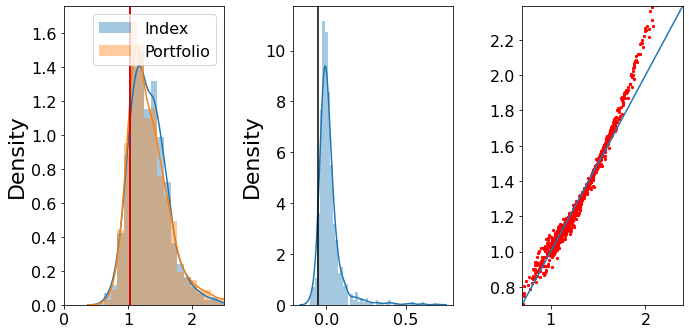

2400 Wass Dist: 0.060245883 Risk Measure: -1.187356 Loss: -0.5936779975891113


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

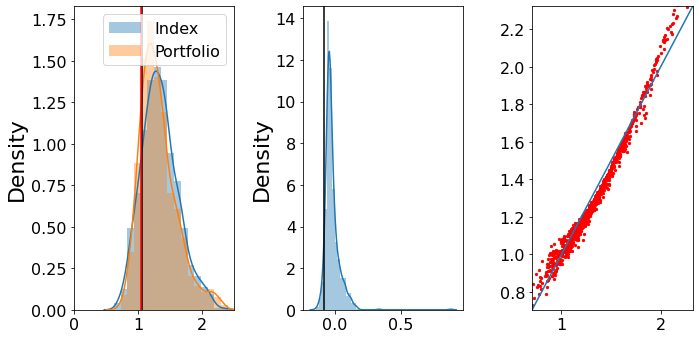

2500 Wass Dist: 0.058140367 Risk Measure: -1.2008948 Loss: -0.600447416305542


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

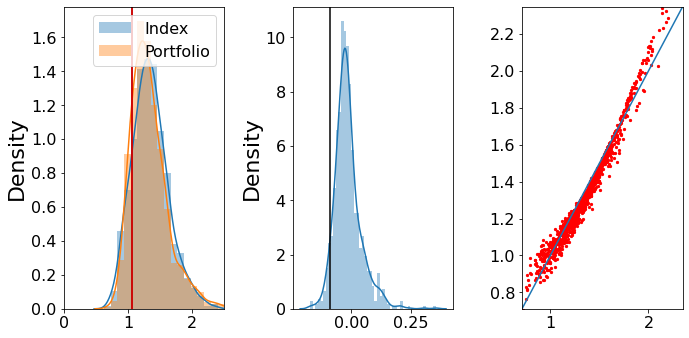

2600 Wass Dist: 0.062409416 Risk Measure: -1.2092905 Loss: -0.6046452522277832


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

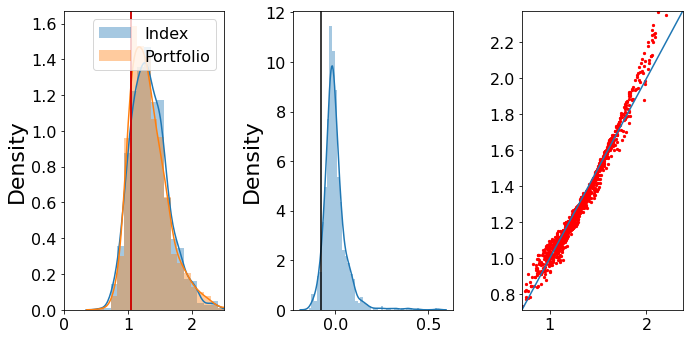

2700 Wass Dist: 0.06589254 Risk Measure: -1.1790466 Loss: -0.5895233154296875


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

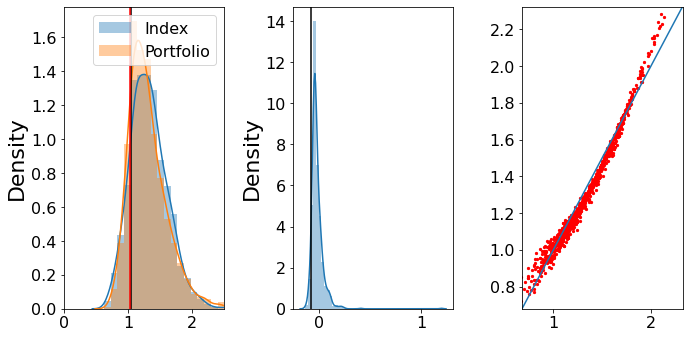

2800 Wass Dist: 0.055304185 Risk Measure: -1.1880082 Loss: -0.5940040946006775


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

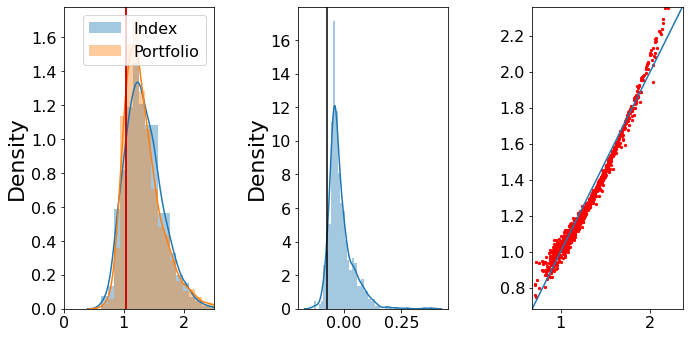

2900 Wass Dist: 0.11469613 Risk Measure: -1.2316073 Loss: 10.531157493591309


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

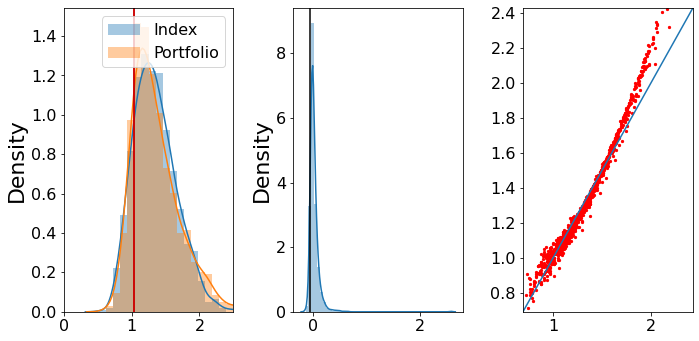

Finished Training


In [15]:
net = MyNet(50).to(device)
RiskMeasure, wass_dist, X_t, Y_t = SimRM(net, params, Nsims=1000, device=device)
PlotHists(X_t, Y_t)

# create  optimizer
optimizer = optim.Adam(net.parameters())

Nepochs = 3000
loss_hist = []
risk_history = []
wass_dist_history=[]

for epoch in range(Nepochs):  # loop over the dataset multiple times


    # zero the parameter gradients
    optimizer.zero_grad()

    RiskMeasure, wass_dist,  X_t, Y_t = SimRM(net, params, Nsims=1000, device=device)
    
    
    loss = 10*wass_dist*(wass_dist>0.1) \
        + RiskMeasure/2 \
        + 10*(torch.mean(Y_t)>torch.mean(X_t))
     
    # loss = 10*wass_dist*(wass_dist>0.1) \
    #     + RiskMeasure/2 

    loss.backward()   
    
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    # PlotHists(X_t, Y_t)
    
    # plot output every 50 iterations
    if( (epoch % 100 == 0) and (epoch>1) ):
        print(epoch, end=" ")
        print("Wass Dist:", wass_dist.cpu().detach().numpy(), end=" " )
        print("Risk Measure:", RiskMeasure.cpu().detach().numpy(), end=" ")
        print("Loss:", loss.item())

        PlotHists(X_t, Y_t)
        
        # plt.figure(figsize=(10,5))
        
        # plt.subplot(1,3,1)
        # plt.plot(risk_history)
        # plt.title("RM") 
        
        # plt.subplot(1,3,2)
        # plt.plot(wass_dist_history)
        # plt.title("WD") 
        
        # plt.subplot(1,3,3)
        # plt.plot(loss_hist)
        # plt.title("Loss") 

        # plt.tight_layout()        
        # plt.show()
        

print('Finished Training')

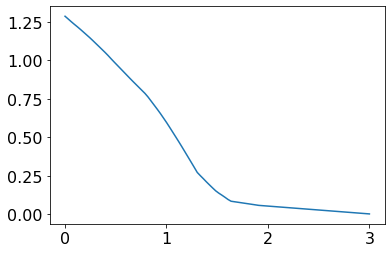

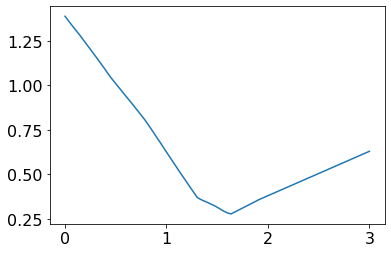

In [24]:
X1_delta_t = np.linspace(0.0, 3, 100)   
X2_delta_t = np.linspace(0.0, 3, 100)   
x = np.zeros((X1_delta_t.shape[0],2))

x[:,0] = X1_delta_t
x[:,1] = X2_delta_t

x_t = torch.tensor(x, dtype=torch.float, device=device )

w_t = net(x_t).cpu().detach().numpy()
x_input = x_t.cpu().detach().numpy()

plt.plot(x_input[:,0],w_t[:,0] )
plt.show()
plt.plot(x_input[:,1],w_t[:,1] )
plt.show()

In [23]:
x_input.shape

(100, 2)

In [22]:
w_t[:,1]

array([1.3885275 , 1.3655895 , 1.3428931 , 1.3207315 , 1.2994608 ,
       1.2775275 , 1.2544053 , 1.2313153 , 1.2082251 , 1.1850231 ,
       1.1617664 , 1.1382947 , 1.1145589 , 1.0906581 , 1.0656184 ,
       1.0421358 , 1.0205668 , 0.9993578 , 0.97814876, 0.95678747,
       0.9355699 , 0.9143898 , 0.8930242 , 0.8713229 , 0.84962153,
       0.8278525 , 0.8057909 , 0.7815038 , 0.7556337 , 0.72976345,
       0.7038933 , 0.67830324, 0.6518577 , 0.625412  , 0.59958184,
       0.57377625, 0.5479704 , 0.5220856 , 0.49641097, 0.47121245,
       0.44601372, 0.42081523, 0.3958153 , 0.3710767 , 0.36072177,
       0.35278088, 0.34547085, 0.33751136, 0.32931376, 0.32086128,
       0.31086963, 0.3002567 , 0.2909321 , 0.28292122, 0.27851656,
       0.28731692, 0.2961173 , 0.30491757, 0.3137179 , 0.32251823,
       0.3313186 , 0.34011889, 0.34899575, 0.35822105, 0.36577478,
       0.37332854, 0.38088226, 0.38843602, 0.39598975, 0.40354347,
       0.41109723, 0.41865104, 0.42620477, 0.4337585 , 0.44131